In [1]:
import pandas as pd

In [2]:
# Exclude some data to make the notebook run faster for testing
DEBUG_FASTER = False

In [3]:
pd.set_option("display.max_rows", 8)

In [4]:
# Load in fully processed (replicate collapsed) data
df_processed = pd.read_csv("data/primary-screen-replicate-collapsed-logfold-change.csv")
df_processed.rename(columns={"Unnamed: 0": "cell_line"}, inplace=True)
df_processed.set_index("cell_line", inplace=True)

# Load in the corresponding column info data
df_info = pd.read_csv("data/primary-screen-replicate-collapsed-treatment-info.csv")

## Q: Why are there 4,686 columns when there were only 4,518 drugs?

Let's first pick these apart by type of screen...

In [5]:
df_info.screen_id.value_counts()

HTS       4147
MTS004     539
Name: screen_id, dtype: int64

Where are the other screens (e.g. MTS006)? Those are part of the secondary screening:

In [6]:
df_info_secondary = pd.read_csv("data/secondary-screen-replicate-collapsed-treatment-info.csv")
df_info_secondary.screen_id.value_counts()

HTS002    11168
MTS010     1240
MTS006      584
MTS005       16
Name: screen_id, dtype: int64

First, let's look at names:

In [7]:
print("There are {} unique drug names".format(df_info.name.nunique()))

There are 4517 unique drug names


### Why 4,517 and not 4,518 unique drug names?

We are missing a drug that isn't labeled:

In [8]:
df_info[df_info.name.isna()]

,column_name,broad_id,name,dose,screen_id,moa,target,disease.area,indication,smiles,phase
2266,BRD-K28042756-001-01-9::5::HTS,BRD-K28042756-001-01-9,NaN,5.0,HTS,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
nan_column = df_info[df_info.name.isna()].iloc[0].column_name
nan_column

'BRD-K28042756-001-01-9::5::HTS'

Is there activity for the unlabeled drug? Is it real? Yes:

In [10]:
df_processed[nan_column]

cell_line
ACH-000001               0.062508
ACH-000007               0.298626
ACH-000008              -0.836430
ACH-000010_FAILED_STR         NaN
                           ...   
ACH-001306               0.115208
ACH-001307              -0.430072
ACH-001318              -0.393414
ACH-001321              -0.272131
Name: BRD-K28042756-001-01-9::5::HTS, Length: 578, dtype: float64

Ok, so let's give it a name:

In [11]:
df_info.name = df_info.name.fillna("unlabeled")

Now we have the expected number of unique drug names:

In [12]:
print("There are {} unique drug names".format(df_info.name.nunique()))

There are 4518 unique drug names


### Next, let's look at dose to better understand what comprises the 4,686 number:

In [13]:
df_name_dose_count = df_info.groupby(["name", "dose"]).count().rename(
    columns={"column_name": "name_dose_count"})[["name_dose_count"]]

In [14]:
print("There are {} unique drug name/dose combinations".format(len(df_name_dose_count)))

There are 4607 unique drug name/dose combinations


In [15]:
print("There are {} unique doses".format(df_info.dose.nunique()))

There are 416 unique doses


In [16]:
df_dose_counts = pd.DataFrame(df_info.dose.value_counts()).rename(columns={"dose": "dose_count"})

The vast majority of doses is 2.5, which is in line with the paper: "A primary screen of 4,518 drugs was performed at 2.5 μM"

In [17]:
df_dose_counts.sort_values(by="dose_count", ascending=False)

,dose_count
2.50,4125
0.25,13
2.58,12
2.52,10
...,...
1.36,1
2.65,1
2.89,1
0.94,1


Let's understanding the dosing distribution, given that we only expected to see 2.5:

In [18]:
unique_doses = set(df_info.dose.unique())
unique_doses_series = pd.Series(list(unique_doses))

In [19]:
unique_doses_series.describe()

count    416.000000
mean       2.473920
std        0.352875
min        0.030000
25%        2.479944
50%        2.499998
75%        2.518784
max        5.600000
dtype: float64

In [20]:
import seaborn as sb

<AxesSubplot:>

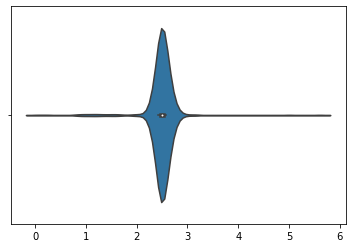

In [21]:
sb.violinplot(x=unique_doses_series)

For each drug name/dose combination, how many columns exist?

In [22]:
df_name_dose_count.sort_values(by="name_dose_count", ascending=False)

,,name_dose_count
name,dose,
cefoselis,2.5,3
tempol,2.5,3
doxycycline,2.5,3
sulpiride,2.5,2
...,...,...
arotinolol,2.5,1
arsanilic-acid,2.5,1
artemisinin,2.5,1
zuclopenthixol,2.5,1


Do the total number of columns add up to 4,686 as expected? Yes:

In [23]:
df_name_dose_count.name_dose_count.sum()

4686

So why is e.g. cefoselis in there 3 times?

In [24]:
drug_name = "cefoselis"
df_info[df_info.name == drug_name]

,column_name,broad_id,name,dose,screen_id,moa,target,disease.area,indication,smiles,phase
3762,BRD-K72339976-065-02-1::2.5::HTS,BRD-K72339976-065-02-1,cefoselis,2.5,HTS,bacterial cell wall synthesis inhibitor,NaN,NaN,NaN,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(Cn3ccc(=N)n3CCO)...,Launched
3763,BRD-K72339976-065-03-9::2.5::HTS,BRD-K72339976-065-03-9,cefoselis,2.5,HTS,bacterial cell wall synthesis inhibitor,NaN,NaN,NaN,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(Cn3ccc(=N)n3CCO)...,Launched
3764,BRD-K72339976-065-04-7::2.5::HTS,BRD-K72339976-065-04-7,cefoselis,2.5,HTS,bacterial cell wall synthesis inhibitor,NaN,NaN,NaN,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(Cn3ccc(=N)n3CCO)...,Launched


Is this a control or an experimental treatment drug?

In [25]:
df_info_replicates = pd.read_csv("data/primary-screen-replicate-treatment-info.csv")

In [26]:
print("{} is an {}".format(
    drug_name,
    " ".join(list(df_info_replicates[df_info_replicates.name == drug_name].perturbation_type.unique()))))

cefoselis is an experimental_treatment


### How different are the results for the same name/dose combination?

For starters, the results for each *are* different:

In [27]:
cefoselis_25_columns = df_info[df_info.name == "cefoselis"].column_name.to_list()

In [28]:
df_processed[cefoselis_25_columns]

,BRD-K72339976-065-02-1::2.5::HTS,BRD-K72339976-065-03-9::2.5::HTS,BRD-K72339976-065-04-7::2.5::HTS
cell_line,,,
ACH-000001,-0.036150,-0.607059,NaN
ACH-000007,0.524170,0.125913,-0.369919
ACH-000008,-0.515084,0.171001,0.087202
ACH-000010_FAILED_STR,0.490244,NaN,0.356100
...,...,...,...
ACH-001306,-0.021689,-0.556729,0.154355
ACH-001307,-0.044736,-0.015259,-0.542601
ACH-001318,0.232368,-0.095139,-0.132654
ACH-001321,0.241290,0.018188,-0.403153


In [29]:
from scipy.spatial.distance import cosine

In [30]:
def distance_between(data, columns, columns_other=None, distance_metric=cosine, print_message=True):
    distances = []
    dropped_row_counts = []
    col_a_names = []
    col_b_names = []
    if columns_other is None:
        columns_other = columns
    else:
        if DEBUG_FASTER:
            columns_other = columns_other[:100]
    for col_a in columns:
        for col_b in columns_other:
            if col_a != col_b:
                data_dropna = data.dropna(subset=[col_a, col_b])
                if print_message:
                    print("Dropping {} of {} rows due to missing values in columns {}".format(
                        len(data) - len(data_dropna),
                        len(data),
                        [col_a, col_b]))
                dropped_row_counts.append(len(data) - len(data_dropna))
                col_a_names.append(col_a)
                col_b_names.append(col_b)
                distances.append(distance_metric(data_dropna[col_a], data_dropna[col_b]))
    return pd.DataFrame({"distance": distances, "dropped_row_count": dropped_row_counts,
                         "col_a": col_a_names, "col_b": col_b_names})

In [31]:
cefoselis_25_distances = distance_between(df_processed, cefoselis_25_columns)

Dropping 44 of 578 rows due to missing values in columns ['BRD-K72339976-065-02-1::2.5::HTS', 'BRD-K72339976-065-03-9::2.5::HTS']
Dropping 21 of 578 rows due to missing values in columns ['BRD-K72339976-065-02-1::2.5::HTS', 'BRD-K72339976-065-04-7::2.5::HTS']
Dropping 44 of 578 rows due to missing values in columns ['BRD-K72339976-065-03-9::2.5::HTS', 'BRD-K72339976-065-02-1::2.5::HTS']
Dropping 51 of 578 rows due to missing values in columns ['BRD-K72339976-065-03-9::2.5::HTS', 'BRD-K72339976-065-04-7::2.5::HTS']
Dropping 21 of 578 rows due to missing values in columns ['BRD-K72339976-065-04-7::2.5::HTS', 'BRD-K72339976-065-02-1::2.5::HTS']
Dropping 51 of 578 rows due to missing values in columns ['BRD-K72339976-065-04-7::2.5::HTS', 'BRD-K72339976-065-03-9::2.5::HTS']


In [32]:
cefoselis_25_distances

,distance,dropped_row_count,col_a,col_b
0,0.856220,44,BRD-K72339976-065-02-1::2.5::HTS,BRD-K72339976-065-03-9::2.5::HTS
1,1.061304,21,BRD-K72339976-065-02-1::2.5::HTS,BRD-K72339976-065-04-7::2.5::HTS
2,0.856220,44,BRD-K72339976-065-03-9::2.5::HTS,BRD-K72339976-065-02-1::2.5::HTS
3,1.035611,51,BRD-K72339976-065-03-9::2.5::HTS,BRD-K72339976-065-04-7::2.5::HTS
4,1.061304,21,BRD-K72339976-065-04-7::2.5::HTS,BRD-K72339976-065-02-1::2.5::HTS
5,1.035611,51,BRD-K72339976-065-04-7::2.5::HTS,BRD-K72339976-065-03-9::2.5::HTS


How does the above compare to the distances between the three cefoselis/2.5 combinations and the rest of the drugs?

In [35]:
df_all_distances_cefoselis_25 = distance_between(
    df_processed, 
    columns=cefoselis_25_columns, 
    columns_other=df_info.column_name.to_list(),
    print_message=False)
df_all_distances_cefoselis_25

,distance,dropped_row_count,col_a,col_b
0,1.076371,36,BRD-K72339976-065-02-1::2.5::HTS,BRD-A00055058-001-01-0::2.325889319::MTS004
1,0.808229,38,BRD-K72339976-065-02-1::2.5::HTS,BRD-A00842753-001-01-9::2.5::MTS004
2,1.052591,36,BRD-K72339976-065-02-1::2.5::HTS,BRD-A02232681-001-01-8::2.5::MTS004
3,0.853346,36,BRD-K72339976-065-02-1::2.5::HTS,BRD-A04447196-001-01-8::2.5::MTS004
...,...,...,...,...
14051,0.890482,17,BRD-K72339976-065-04-7::2.5::HTS,BRD-U25960968-000-01-9::2.5::HTS
14052,1.079440,75,BRD-K72339976-065-04-7::2.5::HTS,BRD-U45393375-000-01-6::2.5::HTS
14053,0.981716,21,BRD-K72339976-065-04-7::2.5::HTS,BRD-U48018661-000-01-9::2.5::HTS
14054,0.883210,21,BRD-K72339976-065-04-7::2.5::HTS,BRD-U51753822-000-01-1::2.5::HTS


<AxesSubplot:>

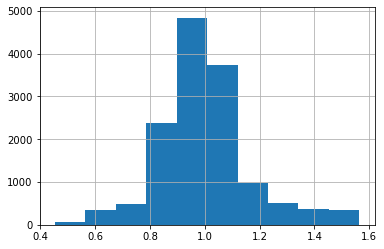

In [36]:
df_all_distances_cefoselis_25.distance.hist()

In [37]:
df_all_distances_cefoselis_25.distance.describe()

count    14055.000000
mean         0.999740
std          0.167101
min          0.453315
25%          0.903775
50%          0.984968
75%          1.071373
max          1.563750
Name: distance, dtype: float64

### So that's strange: the distance between the three cefoselis/2.5 combinations is sizable

The distance between three cefoselis/2.5 combinations and each other is similar to the distance between them and the rest of the drugs.

### How about two similar, but not identical, doses of the same drug?

In [38]:
df_same_name_different_dose_count = df_info[["name", "dose"]].drop_duplicates().groupby("name").count().rename(
    columns={"dose": "name_count"})
df_same_name_different_dose_count.sort_values(by="name_count", ascending=False)

,name_count
name,
piromidic-acid,2
BIX-02188,2
methotrexate,2
sparfloxacin,2
...,...
ardeparin,1
arecaidine-but-2-ynyl-ester,1
arecaidine-propargyl-ester,1
zuclopenthixol,1


In [39]:
drug_name = "paliperidone"
print("{} is an {}".format(
    drug_name,
    " ".join(list(df_info_replicates[df_info_replicates.name == drug_name].perturbation_type.unique()))))

paliperidone is an experimental_treatment


In [40]:
drug_name_columns = df_info[df_info.name == drug_name].column_name.to_list()
df_processed[drug_name_columns]

,BRD-A99888680-001-03-8::2.38::HTS,BRD-A99888680-001-04-6::2.5::HTS
cell_line,,
ACH-000001,0.634714,-0.027650
ACH-000007,-0.995421,-0.073679
ACH-000008,NaN,-0.269418
ACH-000010_FAILED_STR,NaN,0.103702
...,...,...
ACH-001306,0.118545,-0.507825
ACH-001307,0.120775,-0.003516
ACH-001318,0.425228,-0.797057
ACH-001321,0.027278,-0.477762


In [41]:
drug_name_distances = distance_between(df_processed, drug_name_columns)
drug_name_distances

Dropping 91 of 578 rows due to missing values in columns ['BRD-A99888680-001-03-8::2.38::HTS', 'BRD-A99888680-001-04-6::2.5::HTS']
Dropping 91 of 578 rows due to missing values in columns ['BRD-A99888680-001-04-6::2.5::HTS', 'BRD-A99888680-001-03-8::2.38::HTS']


,distance,dropped_row_count,col_a,col_b
0,1.112185,91,BRD-A99888680-001-03-8::2.38::HTS,BRD-A99888680-001-04-6::2.5::HTS
1,1.112185,91,BRD-A99888680-001-04-6::2.5::HTS,BRD-A99888680-001-03-8::2.38::HTS


In [42]:
df_all_distances_piromidic = distance_between(
    df_processed, 
    columns=drug_name_columns, 
    columns_other=df_info.column_name.to_list(),
    print_message=False)

<AxesSubplot:>

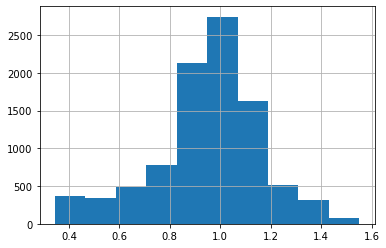

In [43]:
df_all_distances_piromidic.distance.hist()

In [44]:
df_all_distances_piromidic.distance.describe()

count    9370.000000
mean        0.950532
std         0.214583
min         0.344275
25%         0.858307
50%         0.972680
75%         1.077946
max         1.551110
Name: distance, dtype: float64

So here was an example of a drug where we had:
    
* Two different doses (2.5 μM and 2.38 μM), even though the primary screen was supposedly just 2.5 μM
* The difference between the response to those similar doses was significant

### Back to comparing different responses to the same drug name and dose...

Why, in addition to plate/well replicates that were already collapsed, would there be all these same name/dose columns? And why would the differences between responses to the same drug/dose be so sizable?

Next steps:
 
* Look at similarity across replicates
* Look at secondary data to see what dose combinations exist there